# Building a neural network to predict income from description of a film

### SPARQL query to fetch title, description, income of films from dbpedia


SPARQL query to fetch data
```sparql
select distinct ?film ?income ?cat ?desc where {
?film a <http://dbpedia.org/ontology/Film> .
?film <http://dbpedia.org/ontology/gross> ?income .
?film <http://dbpedia.org/ontology/abstract> ?desc .
  {
    ?film <http://purl.org/dc/terms/subject> ?cat . 
    } UNION {
      ?film <http://purl.org/dc/terms/subject> ?scat . 
      ?scat <http://www.w3.org/2004/02/skos/core#broader> ?cat.
  } 
  filter (lang(?desc) = "en")
  filter (lang(?film) = "en")
} group by ?film ?cat ?desc LIMIT 3 OFFSET 100000
```
After doing some requests, I found out that sparql endpoint from dbpedia allows us to get only 10,000 rows at a same time. So, with OFFSET and LIMIT, I managed to get more than 10K entries and I have now a dataset containing 50K rows

## Data understanding

In [1]:
import pandas as pd
import numpy as np

In [2]:
import glob as glob

In [3]:
df = pd.DataFrame()


filepath = ".\data\\" # Local notebook in a data subfolder
# filepath = '.\\' # If using temp files on colab
# filepath = '/content/drive/MyDrive/Cours/Stage/data/' # My drive repo

for filename in glob.glob(filepath + 'data-*.csv'):
    print(f"Concatening {filename} to df...")
    df = pd.concat([df, pd.read_csv(filename)], axis=0)

df.shape

Concatening .\data\data-1.csv to df...
Concatening .\data\data-2.csv to df...
Concatening .\data\data-3.csv to df...
Concatening .\data\data-4.csv to df...
Concatening .\data\data-5.csv to df...


(50000, 4)

In [6]:
df

,film,income,cat,desc
0,http://dbpedia.org/resource/...All_the_Marbles,6500000.0,http://dbpedia.org/resource/Category:Films_sho...,...All the Marbles (reissued as The California...
1,http://dbpedia.org/resource/...All_the_Marbles,6500000.0,http://dbpedia.org/resource/Category:Films_sho...,...All the Marbles (reissued as The California...
2,http://dbpedia.org/resource/...All_the_Marbles,2200000.0,http://dbpedia.org/resource/Category:1981_films,...All the Marbles (reissued as The California...
3,http://dbpedia.org/resource/...All_the_Marbles,2200000.0,http://dbpedia.org/resource/Category:Metro-Gol...,...All the Marbles (reissued as The California...
4,http://dbpedia.org/resource/...All_the_Marbles,2200000.0,http://dbpedia.org/resource/Category:American_...,...All the Marbles (reissued as The California...
...,...,...,...,...
9995,http://dbpedia.org/resource/The_Family_Man,124700000.0,http://dbpedia.org/resource/Category:American_...,The Family Man is a 2000 American romantic fan...
9996,http://dbpedia.org/resource/The_Bells_of_St._M...,21333333.0,http://dbpedia.org/resource/Category:Films_abo...,The Bells of St. Mary's (1945) is an American ...
9997,http://dbpedia.org/resource/The_French_Connect...,51700000.0,http://dbpedia.org/resource/Category:Organized...,The French Connection is a 1971 American crime...
9998,http://dbpedia.org/resource/The_Toxic_Avenger_...,800000.0,http://dbpedia.org/resource/Category:Horror_fi...,The Toxic Avenger is a 1984 American superhero...


In [7]:
df = df.drop_duplicates()

df = pd.concat([df.groupby("film").mean(), df.groupby('film').nth(0).film, df.groupby('film').nth(0).cat, df.groupby("film").nth(0).desc], axis=1)
df.head()

Creating another dataset to map each film to its related categories

In [8]:
df_cat = pd.concat([df.film, df.cat], axis=1)
df_cat.head()

,film,cat
0,http://dbpedia.org/resource/...All_the_Marbles,http://dbpedia.org/resource/Category:Films_sho...
1,http://dbpedia.org/resource/...All_the_Marbles,http://dbpedia.org/resource/Category:Films_sho...
2,http://dbpedia.org/resource/...All_the_Marbles,http://dbpedia.org/resource/Category:1981_films
3,http://dbpedia.org/resource/...All_the_Marbles,http://dbpedia.org/resource/Category:Metro-Gol...
4,http://dbpedia.org/resource/...All_the_Marbles,http://dbpedia.org/resource/Category:American_...


Normalizing categories to not have the full link

In [9]:
def normalize_cat(x):
    return "".join(x.split(':')[2])

df_cat['cat_p'] = df_cat['cat'].apply(lambda x: normalize_cat(x))

In [10]:
df_cat.head()

,film,cat,cat_p
0,http://dbpedia.org/resource/...All_the_Marbles,http://dbpedia.org/resource/Category:Films_sho...,Films_shot_in_Ohio
1,http://dbpedia.org/resource/...All_the_Marbles,http://dbpedia.org/resource/Category:Films_sho...,"Films_shot_in_Youngstown,_Ohio"
2,http://dbpedia.org/resource/...All_the_Marbles,http://dbpedia.org/resource/Category:1981_films,1981_films
3,http://dbpedia.org/resource/...All_the_Marbles,http://dbpedia.org/resource/Category:Metro-Gol...,Metro-Goldwyn-Mayer_films
4,http://dbpedia.org/resource/...All_the_Marbles,http://dbpedia.org/resource/Category:American_...,American_comedy-drama_films


Getting unique films, mean of all the incomes related and unique descriptions

In [11]:
films = df.film.unique()

incomes = []
for f in films:
    incomes.append(df[df.film == f].income.mean())

In [12]:
df_film = pd.DataFrame(films)
df_desc = pd.DataFrame(df.desc.unique())
df_income = pd.DataFrame(incomes)

df_new = pd.DataFrame()
df_new['film'] = df_film
df_new['income'] = df_income
df_new['desc'] = df_desc

df_new.head()

,film,income,desc
0,http://dbpedia.org/resource/...All_the_Marbles,4.515385e+06,...All the Marbles (reissued as The California...
1,"http://dbpedia.org/resource/20,000_Years_in_Si...",9.350000e+05,"20,000 Years in Sing Sing is a 1932 American P..."
2,http://dbpedia.org/resource/ABBA:_The_Movie,5.347122e+06,ABBA: The Movie is a 1977 mocumentary about th...
3,http://dbpedia.org/resource/A_Christmas_Carol_...,3.250000e+08,"Disney's A Christmas Carol, or simply A Christ..."
4,http://dbpedia.org/resource/A_Funny_Thing_Happ...,3.400000e+06,A Funny Thing Happened on the Way to the Forum...


In [13]:
df = df_new

Removing outliers

In [14]:
zscore = (df.income - df.income.mean()) / df.income.std()
dfwo = df[abs(zscore)<2.0]


dfwo=df[df.income < 500000000]
# dfwo.describe() 

In [16]:
# dfwo.shape

In [17]:
MEDIAN_VALUE = dfwo[dfwo.income < 10000000].income.median()
# MEDIAN_VALUE

## Preprocessing


### Overall data

Creating 3 classes for our NN to classify:
- [< MEDIAN-VALUE] : Medium-Low
- [MEDIAN-VALUE - 10e6] : Medium-High
- [> 10e6] : Exceptional

In [18]:
dfwo.loc[(dfwo.income >= 0), 'income_c'] = 'medium-low'
dfwo.loc[(dfwo.income >= MEDIAN_VALUE), 'income_c'] = 'medium-high'
dfwo.loc[(dfwo.income >= 10e6), 'income_c'] = 'exceptional'
dfwo.head()

D:\users\maxim\anaconda3\envs\rnn-films\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
D:\users\maxim\anaconda3\envs\rnn-films\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,film,income,desc,income_c
0,http://dbpedia.org/resource/...All_the_Marbles,4.515385e+06,...All the Marbles (reissued as The California...,medium-high
1,"http://dbpedia.org/resource/20,000_Years_in_Si...",9.350000e+05,"20,000 Years in Sing Sing is a 1932 American P...",medium-low
2,http://dbpedia.org/resource/ABBA:_The_Movie,5.347122e+06,ABBA: The Movie is a 1977 mocumentary about th...,medium-high
3,http://dbpedia.org/resource/A_Christmas_Carol_...,3.250000e+08,"Disney's A Christmas Carol, or simply A Christ...",exceptional
4,http://dbpedia.org/resource/A_Funny_Thing_Happ...,3.400000e+06,A Funny Thing Happened on the Way to the Forum...,medium-high


### Text description

Function removing stopwords, links, digits, ...

In [19]:
import string
import re
import nltk
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('english')

def clean_text(text):
  text = "".join([word.lower() for word in text if word not in string.punctuation])
  
  # Remove links starting with http
  text1 = re.sub(r'http\S+', ' ', text)

  # Remove digits
  text2 = re.sub(r'\d+', ' ', text1)
  tokens = re.split('\W+', text2)
  text = [word for word in tokens if word not in stopwords+[""]] # MdA: Added the empty string to stopwords

  return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maxim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Applying the function to all the DataFrame

In [22]:
dfwo['desc_p'] = dfwo['desc'].apply(lambda x: clean_text(x))
# MdA: created a new column, as otherwise when applied twice it 
# messes things up
dfwo

C:\Users\maxim\AppData\Local\Temp/ipykernel_5208/555644315.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfwo['desc_p'] = dfwo['desc'].apply(lambda x: clean_text(x))


,film,income,desc,income_c,desc_p
0,http://dbpedia.org/resource/...All_the_Marbles,4.515385e+06,...All the Marbles (reissued as The California...,medium-high,"[marbles, reissued, california, dolls, comedyd..."
1,"http://dbpedia.org/resource/20,000_Years_in_Si...",9.350000e+05,"20,000 Years in Sing Sing is a 1932 American P...",medium-low,"[years, sing, sing, american, precode, drama, ..."
2,http://dbpedia.org/resource/ABBA:_The_Movie,5.347122e+06,ABBA: The Movie is a 1977 mocumentary about th...,medium-high,"[abba, movie, mocumentary, swedish, pop, group..."
3,http://dbpedia.org/resource/A_Christmas_Carol_...,3.250000e+08,"Disney's A Christmas Carol, or simply A Christ...",exceptional,"[disneys, christmas, carol, simply, christmas,..."
4,http://dbpedia.org/resource/A_Funny_Thing_Happ...,3.400000e+06,A Funny Thing Happened on the Way to the Forum...,medium-high,"[funny, thing, happened, way, forum, britisham..."
...,...,...,...,...,...
14502,http://dbpedia.org/resource/The_Escape_(2017_f...,5.112030e+05,The Escape is a 2017 British drama film direct...,medium-low,"[escape, british, drama, film, directed, domin..."
14503,http://dbpedia.org/resource/The_Summer_House,7.090000e+02,Les Estivants (transl. The Summer House) is a ...,medium-low,"[les, estivants, transl, summer, house, french..."
14504,http://dbpedia.org/resource/Atlantic_City_(198...,1.270000e+07,"Atlantic City (French: Atlantic City, USA) is ...",exceptional,"[atlantic, city, french, atlantic, city, usa, ..."
14505,http://dbpedia.org/resource/Dead_Men_Don't_Wea...,1.800000e+07,Dead Men Don't Wear Plaid is a 1982 American n...,exceptional,"[dead, men, dont, wear, plaid, american, neono..."


#### We want to get all the categories for each film and then make a dedicated column

In [23]:
# we get categories from the film uri
def get_cats_from_film(film):
    cats= []
    fetch_cats = df_cat[df_cat.film == film].cat_p.unique()
    for cat in fetch_cats:
        cats.append(cat)
        
    return cats

Had to reset index because some rows were wrongly indexed (stepped from 54 to 56 in 1 line)

In [42]:
dfwo = dfwo.reset_index()

We don't want to concat because it messes a bit in pandas

In [43]:
dict_df = {
    'film': dfwo.film,
    'income': dfwo.income,
    'desc': dfwo.desc,
    'income_c': dfwo.income_c,
    'desc_p': dfwo.desc_p,
    'categories': []
}

for i in range(len(dfwo.film)):
    dict_df["categories"].append(get_cats_from_film(dfwo.film.loc[i]))

In [44]:
pd.DataFrame().from_dict(dict_df)

,film,income,desc,income_c,desc_p,categories
0,http://dbpedia.org/resource/...All_the_Marbles,4.515385e+06,...All the Marbles (reissued as The California...,medium-high,"[marbles, reissued, california, dolls, comedyd...","[Films_shot_in_Ohio, Films_shot_in_Youngstown,..."
1,"http://dbpedia.org/resource/20,000_Years_in_Si...",9.350000e+05,"20,000 Years in Sing Sing is a 1932 American P...",medium-low,"[years, sing, sing, american, precode, drama, ...","[American_prison_drama_films, 1930s_prison_fil..."
2,http://dbpedia.org/resource/ABBA:_The_Movie,5.347122e+06,ABBA: The Movie is a 1977 mocumentary about th...,medium-high,"[abba, movie, mocumentary, swedish, pop, group...","[Films_set_in_Australia, ABBA, Australian_docu..."
3,http://dbpedia.org/resource/A_Christmas_Carol_...,3.250000e+08,"Disney's A Christmas Carol, or simply A Christ...",exceptional,"[disneys, christmas, carol, simply, christmas,...","[Films_using_motion_capture, 2000s_fantasy_adv..."
4,http://dbpedia.org/resource/A_Funny_Thing_Happ...,3.400000e+06,A Funny Thing Happened on the Way to the Forum...,medium-high,"[funny, thing, happened, way, forum, britisham...","[Films_scored_by_Ken_Thorne, Films_based_on_wo..."
...,...,...,...,...,...,...
14145,http://dbpedia.org/resource/The_Escape_(2017_f...,5.112030e+05,The Escape is a 2017 British drama film direct...,medium-low,"[escape, british, drama, film, directed, domin...",[Films_by_country]
14146,http://dbpedia.org/resource/The_Summer_House,7.090000e+02,Les Estivants (transl. The Summer House) is a ...,medium-low,"[les, estivants, transl, summer, house, french...",[Drama_films_by_country]
14147,http://dbpedia.org/resource/Atlantic_City_(198...,1.270000e+07,"Atlantic City (French: Atlantic City, USA) is ...",exceptional,"[atlantic, city, french, atlantic, city, usa, ...","[Atlantic_City,_New_Jersey_in_fiction]"
14148,http://dbpedia.org/resource/Dead_Men_Don't_Wea...,1.800000e+07,Dead Men Don't Wear Plaid is a 1982 American n...,exceptional,"[dead, men, dont, wear, plaid, american, neono...",[Compositions_by_Miklós_Rózsa]


In [21]:
X = dfwo['desc_p'] # MdA: use the new column
y = dfwo['income_c']

### One-hot encoding on target column

In [28]:
y = pd.get_dummies(y)
y.head()

,exceptional,medium-high,medium-low
0,0,1,0
1,0,0,1
2,0,1,0
3,1,0,0
4,0,1,0


### Splitting train & test set

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [31]:
print(X_train.shape)
print(X_test.shape)

(11320,)
(2830,)


In [32]:
print(y_train.shape)
print(y_test.shape)

(11320, 3)
(2830, 3)


### Tokenizing text

In [33]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# The maximum number of words to be used (most frequent)
MAX_NB_WORDS = 10000

# Max number of words in each Tweet
MAX_SEQUENCE_LENGTH = 100

# Intialize and fit the tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True, split=' ')
tokenizer.fit_on_texts(X_train)

Transforming into numerical sequences

In [34]:
# Use that tokenizer to transform the text messages in the training and test sets
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

print(X_train[10])
print(X_train_seq[10])

['advance', 'rear', 'lighthearted', 'american', 'western', 'comedy', 'film', 'set', 'american', 'civil', 'war', 'directed', 'george', 'marshall', 'starring', 'glenn', 'ford', 'stella', 'stevens', 'melvyn', 'douglas', 'film', 'based', 'novel', 'company', 'cowards', 'jack', 'schaefer', 'whose', 'inspiration', 'article', 'william', 'chamberlain', 'published', 'saturday', 'evening', 'post', 'chamberlain', 'recounts', 'apocryphal', 'civil', 'war', 'stories', 'company', 'q', 'th', 'century', 'army', 'slang', 'sick', 'list', 'unit', 'composed', 'coward', 'soldiers', 'given', 'second', 'chance', 'prove', 'bravery', 'film', 'novel', 'title', 'preproduction', 'released', 'united', 'kingdom', 'however', 'novel', 'none', 'comedic', 'elements', 'film', 'retained', 'basic', 'idea', 'unit', 'formed', 'men', 'courtmartialed', 'cowardice', 'sent', 'west', 'well', 'character', 'names']
[808, 3, 41, 109, 18, 72, 1, 2, 8287, 1, 278, 123, 45, 160, 130, 145, 46, 12, 74, 2882, 4927, 2253, 999, 292, 383, 87, 

Get max length of a sequence in the DataFrame and the value of the mean + the standard deviation

In [35]:
from statistics import *

def get_max_len(seq):
    max_len = 0
    for x in seq:
        if len(x) > max_len:
            max_len = len(x)
    return max_len

def get_mean_std_len(seq):
    values = []
    for x in seq:
        values.append(len(x))
    
    std = stdev(values)
    m = mean(values)
    return int(m + std)

print(f"Max len: {get_max_len(X_train_seq)}")
print(f"Mean + std: {get_mean_std_len(X_train_seq)}")

Max len: 322
Mean + std: 99


Padding the sequence so each sequence has the same length

In [36]:
# X_train_seq_padded = pad_sequences(X_train_seq, 100)
# X_train_seq_padded = pad_sequences(X_train_seq, 44)
# X_train_seq_padded = pad_sequences(X_train_seq, get_max_len(X_train_seq))
X_train_seq_padded = pad_sequences(X_train_seq, get_mean_std_len(X_train_seq))

# X_test_seq_padded = pad_sequences(X_test_seq, 100)
# X_test_seq_padded = pad_sequences(X_test_seq, 44)
# X_test_seq_padded = pad_sequences(X_test_seq, get_max_len(X_train_seq))
X_test_seq_padded = pad_sequences(X_test_seq, get_mean_std_len(X_train_seq))

X_train_seq_padded[10]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        808,    3,   41,  109,   18,   72,    1,    2, 8287,    1,  278,
        123,   45,  160,  130,  145,   46,   12,   74, 2882, 4927, 2253,
        999,  292,  383,   87, 2883,  122,  166,    1,   77,   70, 8287])

In [37]:
print('X_train_seq_padded:', X_train_seq_padded.shape)
print('X_test_seq_padded:', X_test_seq_padded.shape)

print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train_seq_padded: (11320, 99)
X_test_seq_padded: (2830, 99)
y_train: (11320, 3)
y_test: (2830, 3)


## Model Building

In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, SpatialDropout1D
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta, Adagrad
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(input_dim=MAX_NB_WORDS, output_dim=64, input_length=X_train_seq_padded.shape[1]))

# model.add(SpatialDropout1D(0.4))

# Need to activate with tanh and set recurrent_dropout to 0 for the GPU to process
# Initially activation='relu' & recurrent_dropout=0.2
model.add(LSTM(128, activation='tanh', dropout=0.2, recurrent_dropout=0, return_sequences=True, name="lstm_1"))
model.add(LSTM(128, activation='tanh', dropout=0.2, recurrent_dropout=0, return_sequences=True, name="lstm_2"))
model.add(LSTM(128, activation='tanh', dropout=0.2, recurrent_dropout=0, name="lstm_3"))

model.add(Dense(64, activation='relu')) 

# model.add(Dropout(0.4))

model.add(Dense(3, activation='softmax')) 


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 99, 64)            640000    
                                                                 
 lstm_1 (LSTM)               (None, 99, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 99, 128)           131584    
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1,010,435
Trainable params: 1,010,435
Non-

optimizers : https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
- https://deepdatascience.wordpress.com/2016/11/18/which-lstm-optimizer-to-use/
-https://deepdatascience.files.wordpress.com/2016/11/contours_evaluation_optimizers.gif?w=616
- https://deepdatascience.files.wordpress.com/2016/11/saddle_point_evaluation_optimizers.gif?w=616

loss fns : https://www.tensorflow.org/api_docs/python/tf/keras/losses

metrics : https://www.tensorflow.org/api_docs/python/tf/keras/metrics

Compile the model

In [ ]:
# model.compile(optimizer=Adam(learning_rate=0.0001, clipnorm=0.001, clipvalue=0.5), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=RMSprop(learning_rate=0.0001, clipnorm=0.001, clipvalue=0.5), loss='categorical_crossentropy', metrics=['accuracy'])

# Adding an early stopping
es = EarlyStopping(monitor='val_accuracy', 
                   mode='max', 
                   patience=3, #Stop the model training if the validation accuracy doesnt increase in 3 consecutive Epochs
                   restore_best_weights=True)

In [ ]:
BATCH_SIZE = 64
EPOCHS = 30

Fit the RNN

In [ ]:
# For the GPU training
with tf.device('/device:GPU:0'):
    history = model.fit(X_train_seq_padded, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_test_seq_padded, y_test))
  
# history = model.fit(X_train_seq_padded, y_train, batch_size=BATCH_SIZE, callbacks=[es], 
#                     epochs=EPOCHS, validation_data=(X_test_seq_padded, y_test))

Epoch 1/30
177/177 [==============================] - 15s 43ms/step - loss: 1.0307 - accuracy: 0.4708 - val_loss: 1.0039 - val_accuracy: 0.4799
Epoch 2/30
177/177 [==============================] - 6s 35ms/step - loss: 0.9472 - accuracy: 0.5178 - val_loss: 0.9409 - val_accuracy: 0.5194
Epoch 3/30
177/177 [==============================] - 6s 35ms/step - loss: 0.8867 - accuracy: 0.5553 - val_loss: 0.9193 - val_accuracy: 0.5488
Epoch 4/30
177/177 [==============================] - 6s 35ms/step - loss: 0.8425 - accuracy: 0.5851 - val_loss: 0.8963 - val_accuracy: 0.5590
Epoch 5/30
177/177 [==============================] - 6s 35ms/step - loss: 0.8062 - accuracy: 0.6148 - val_loss: 0.8885 - val_accuracy: 0.5770
Epoch 6/30
177/177 [==============================] - 7s 42ms/step - loss: 0.7724 - accuracy: 0.6420 - val_loss: 0.8994 - val_accuracy: 0.5809
Epoch 7/30
177/177 [==============================] - 12s 65ms/step - loss: 0.7423 - accuracy: 0.6612 - val_loss: 0.9026 - val_accuracy: 0.57

(optional) Save the model

In [ ]:
model.save('./rnn-3')

INFO:tensorflow:Assets written to: ./rnn-3\assets


INFO:tensorflow:Assets written to: ./rnn-3\assets


Might be overfitting https://datascience.stackexchange.com/questions/97132/my-lstm-has-a-really-low-accuracy-is-there-anyway-to-improve-it

Ways to reduce overfitting:
- use more data
- Add dropout layer
- reduce the number of neurons at each layer of the model
- use a different metric rather than **accuracy**
- use **batch normalization** instead of **Dropout**

Other theory is : **Exploding gradient** and could be resolved with **gradient clipping**

https://machinelearningmastery.com/exploding-gradients-in-neural-networks/

So, maybe use a smaller batch size ??

"In the Keras deep learning library, you can use gradient clipping by setting the clipnorm or clipvalue arguments on your optimizer before training. Good default values are **clipnorm=1.0** and **clipvalue=0.5**."

## Model Evaluation

#### Plotting model performance
Get values of accuracy, val_accuracy, loss and val_loss to plot them

In [ ]:
import plotly.express as px

def plot_acc_loss():
  
  h = history.history

  df_acc = pd.DataFrame()
  df_acc["acc"] = h['accuracy']
  df_acc["val_acc"] = h['val_accuracy']

  df_loss = pd.DataFrame()

  df_loss["loss"] = h['loss']
  df_loss["val_loss"] = h['val_loss']

  fig = px.line(df_acc, title='Accuracy of the model', labels = {'index': "Epoch"}, width=800, height=400)
  fig.show()

  fig = px.line(df_loss, title='Loss of the model', labels = {'index': "Epoch"}, width=800, height=400)
  fig.show()

In [ ]:
plot_acc_loss()

In [ ]:
score = model.evaluate(X_test_seq_padded, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.269051194190979
Test accuracy: 0.5600706934928894


In [ ]:
y_test

,exceptional,medium-high,medium-low
736,1,0,0
3366,0,0,1
4113,1,0,0
14030,1,0,0
1080,0,1,0
...,...,...,...
5617,1,0,0
11156,1,0,0
110,0,1,0
9141,0,0,1


#### Confusion Matrix

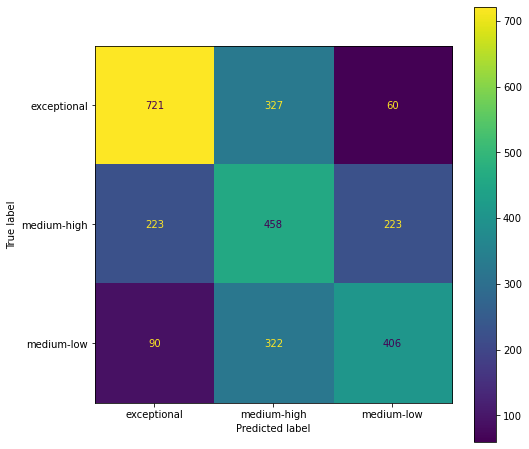

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8))

y_pred = model.predict(X_test_seq_padded) # MdA: get the predictions for X_test

# MdA: show the confusion matrix
y_pred_r = np.argmax(y_pred, axis=1)
y_test_r = np.argmax(np.array(y_test), axis=1)
matrix = confusion_matrix(y_test_r,y_pred_r)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["exceptional","medium-high","medium-low"])
disp.plot(ax=ax)

In [ ]:
model.optimizer.learning_rate, model.optimizer.clipnorm, model.optimizer.clipvalue

(<tf.Variable 'RMSprop/learning_rate:0' shape=() dtype=float32, numpy=1e-04>,
 0.001,
 0.5)

## To load the model

In [38]:
from tensorflow import keras
# model_loaded = keras.models.load_model("/content/drive/MyDrive/Cours/Stage/models/rnn-3")
model_loaded = keras.models.load_model("./models/rnn-3")
model_loaded

**ERASE THE PREVIOUS MODEL**

In [39]:
model = model_loaded

# Visualize and understand neuron activations

In [40]:
list(map(lambda x: x.name, model.layers))

['embedding_2', 'lstm_1', 'lstm_2', 'lstm_3', 'dense_4', 'dense_5']

### Re-creating second model 
Re-creating second model identical from the one trained but removing the last dense layer to collect activations values

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 99, 64)            640000    
                                                                 
 lstm_1 (LSTM)               (None, 99, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 99, 128)           131584    
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1,010,435
Trainable params: 1,010,435
No

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout

In [43]:
model2 = Sequential()
model2.add(Embedding(input_dim=MAX_NB_WORDS, output_dim=64, input_length=X_train_seq_padded.shape[1], weights=model.layers[0].get_weights()))

activations_embedding = model2.predict(X_test_seq_padded)
activations_embedding.shape

(2830, 99, 64)

In [44]:
for i, layer in enumerate(model.layers):
  print(i, layer.name)

0 embedding_2
1 lstm_1
2 lstm_2
3 lstm_3
4 dense_4
5 dense_5


In [45]:
model2 = Sequential()
model2.add(Embedding(input_dim=MAX_NB_WORDS, output_dim=64, input_length=X_train_seq_padded.shape[1], weights=model.layers[0].get_weights()))

model2.add(LSTM(128, activation='tanh', dropout=0.2, recurrent_dropout=0, return_sequences=True, name="lstm_1", weights=model.layers[1].get_weights()))
model2.add(LSTM(128, activation='tanh', dropout=0.2, recurrent_dropout=0, return_sequences=True, name="lstm_2", weights=model.layers[2].get_weights()))
model2.add(LSTM(128, activation='tanh', dropout=0.2, recurrent_dropout=0, name="lstm_3", weights=model.layers[3].get_weights()))

model2.add(Dense(64, activation='relu', weights=model.layers[4].get_weights())) 

In [46]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 99, 64)            640000    
                                                                 
 lstm_1 (LSTM)               (None, 99, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 99, 128)           131584    
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
Total params: 1,010,240
Trainable params: 1,010,240
Non-trainable params: 0
_________________________________________________________________


In [55]:
# activations = model2.predict(X_test_seq_padded) # For the testing set
activations = model2.predict(X_train_seq_padded) # For the training set
activations

array([[0.42408407, 0.        , 0.4522775 , ..., 0.16956973, 0.3094347 ,
        0.2325256 ],
       [0.7305637 , 0.        , 0.17059821, ..., 0.        , 0.18485   ,
        0.6311194 ],
       [0.5608548 , 0.        , 0.5384886 , ..., 0.17914645, 0.46195993,
        0.17843725],
       ...,
       [0.        , 0.41503742, 0.3366306 , ..., 0.83350116, 0.5518092 ,
        0.        ],
       [0.39822674, 0.        , 0.5602442 , ..., 0.22840767, 0.44290227,
        0.        ],
       [0.08341982, 0.3964817 , 0.3256935 , ..., 0.5876627 , 0.5485474 ,
        0.        ]], dtype=float32)

In [56]:
activations.T.shape

(64, 11320)

In [57]:
activations.shape

(11320, 64)

In [58]:
pd.DataFrame(activations).describe()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
count,11320.000000,11320.000000,11320.000000,11320.000000,11320.000000,11320.000000,11320.000000,11320.000000,11320.000000,11320.000000,...,11320.000000,11320.000000,11320.000000,11320.000000,11320.000000,11320.000000,11320.000000,11320.000000,11320.000000,11320.000000
mean,0.351617,0.254362,0.587871,0.236432,0.294778,0.448909,0.132937,0.185228,0.381414,0.092129,...,0.518814,0.218555,0.400909,0.130058,0.425172,0.539357,0.992281,0.513448,0.635403,0.123101
std,0.271169,0.368086,0.449143,0.315483,0.292325,0.679850,0.203873,0.212957,0.539319,0.165341,...,0.407480,0.379453,0.552039,0.223455,0.357445,0.466813,0.636384,0.661044,0.428797,0.203950
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.303191,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.028687,0.000000,0.515249,0.049136,0.349372,0.000000
50%,0.406202,0.021398,0.486815,0.149618,0.270241,0.047359,0.000000,0.103185,0.000000,0.000000,...,0.597422,0.000000,0.045229,0.000000,0.444115,0.610713,1.015144,0.228309,0.523876,0.000000
75%,0.583345,0.431989,0.690362,0.313908,0.545045,0.722925,0.231913,0.336756,0.744206,0.135469,...,0.867932,0.341560,0.736448,0.200778,0.706042,0.932479,1.344925,0.676782,0.755241,0.204197
max,0.910211,1.487581,2.088205,1.376094,1.047652,2.648360,0.960794,0.946525,1.640502,1.001208,...,1.584331,1.984985,1.736867,1.223305,1.246049,1.741151,2.573703,2.620119,2.108414,1.024305


In [59]:
activations[0].shape

(64,)

Creating DataFrame containing neurons and activations values for each neuron

In [60]:
def get_activation_matrix_per_neuron(activations):
    df = pd.DataFrame()

    # MH: transpose the matrix to have neurons as index
    for neuron_index, value_list in enumerate(activations.T):
      # print(neuron_index, value_list)
      index = f"neuron_{neuron_index + 1}" # Should we let 1st neuron at 0 ?
      df[index] = value_list

    return df

In [61]:
df_act_matrix = get_activation_matrix_per_neuron(activations)
df_act_matrix

,neuron_1,neuron_2,neuron_3,neuron_4,neuron_5,neuron_6,neuron_7,neuron_8,neuron_9,neuron_10,...,neuron_55,neuron_56,neuron_57,neuron_58,neuron_59,neuron_60,neuron_61,neuron_62,neuron_63,neuron_64
0,0.424084,0.000000,0.452278,0.291724,0.459992,0.000000,0.273046,0.205086,0.000000,0.248849,...,0.633797,0.498378,0.000000,0.226697,0.000000,0.686606,0.093570,0.169570,0.309435,0.232526
1,0.730564,0.000000,0.170598,0.376262,0.722307,0.000000,0.631108,0.633560,0.000000,0.538720,...,1.017032,1.244231,0.000000,0.678127,0.000000,1.110830,0.000000,0.000000,0.184850,0.631119
2,0.560855,0.000000,0.538489,0.277255,0.602126,0.000000,0.223799,0.250902,0.000000,0.099382,...,0.787969,0.434829,0.000000,0.164589,0.085680,0.996756,0.633387,0.179146,0.461960,0.178437
3,0.311678,0.361044,0.750502,0.000000,0.000000,0.398532,0.000000,0.000000,0.339130,0.000000,...,0.442646,0.000000,0.390990,0.000000,0.513794,0.310550,1.387266,0.469640,0.747502,0.000000
4,0.288678,0.278253,0.685035,0.000000,0.031736,0.251514,0.000000,0.000000,0.215862,0.000000,...,0.539713,0.000000,0.254578,0.000000,0.678507,0.414084,1.333957,0.365494,0.743808,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11315,0.000000,0.654084,1.050048,0.494809,0.000000,1.404541,0.000000,0.000000,1.240332,0.000000,...,0.000000,0.000000,1.406528,0.000000,0.686145,0.000000,1.736108,1.597413,1.217554,0.000000
11316,0.495441,0.000000,0.494167,0.220514,0.539880,0.000000,0.150141,0.148802,0.000000,0.037740,...,0.672221,0.193410,0.000000,0.079942,0.062148,0.855929,0.719169,0.135683,0.403112,0.094133
11317,0.000000,0.415037,0.336631,0.000000,0.000000,0.833745,0.000000,0.000000,0.830642,0.000000,...,0.000000,0.000000,0.933767,0.000000,0.786200,0.000000,1.167060,0.833501,0.551809,0.000000
11318,0.398227,0.000000,0.560244,0.130080,0.365205,0.093118,0.041712,0.000000,0.000000,0.000000,...,0.506393,0.000000,0.069542,0.000000,0.000000,0.582270,0.729548,0.228408,0.442902,0.000000


In [83]:
# We search for the film associated to a sequence of preprocessed words
def get_film_from_seq(seq):
    for i in range(len(dfwo.desc_p)):
        if dfwo.desc_p.iloc[i] == seq:
            return dfwo.iloc[i] # added [0]
    return pd.DataFrame()

# Then we get categories from the film uri
def get_cats_from_film(film):
    cats= []
    fetch_cats = df_cat[df_cat.film == film].cat_p.unique()
    for cat in fetch_cats:
        cats.append(cat)
        
    return cats

# Upper function which gets categories for a given sequence
def get_cats_from_seq(seq):
    return get_cats_from_film(get_film_from_seq(seq).film)

# Get the index of a given sequence from the testing set
def get_seq_index_test(seq):
    for i in range(len(X_test)):
        if X_test.iloc[i] == seq:
            return i
    return None

# Get the index of a given sequence from the training set
def get_seq_index_train(seq):
    for i in range(len(X_train)):
        if X_train.iloc[i] == seq:
            return i
    return None

# Get the preprocessed seq padded from a sequence from the testing set
def get_padded_seq_from_seq_test(seq):
    seq_index = get_seq_index(seq)
    return X_test_seq_padded[seq_index]

# Get thepreprocessed seq padded from a sequence from the training set
def get_padded_seq_from_seq_train(seq):
    seq_index = get_seq_index(seq)
    return X_train_seq_padded[seq_index]

# Return predicted class for a given sequence
def get_pred_from_seq(seq, y_pred):
    # Get padded sequence, then predict with the saved and trained model
    seq_index = get_seq_index_train(seq)
#     y_pred = model.predict(X_test_seq_padded)
    
    seq_pred = y_pred[seq_index]
    
    # np argmax
    return np.argmax(seq_pred)

# Return true class for a given sequence
# Fetch the film from the sequence, then get its income in dfwo and return its index from CLASSES
def get_class_from_seq(seq):
    CLASSES = [
        "exceptional",
        'medium-high',
        "medium-low"
    ] # Classes are indexed such as this because we one-hot encoded like that
    
    # Get film
    film = get_film_from_seq(seq)
    # Fetch income_c in dfwo
    cl = dfwo[dfwo.film == film.film].income_c.iloc[0]
    
    return CLASSES.index(cl)

In [88]:
def create_full_df(activation_matrix_per_neuron, y_pred):
    dict_full_df = {
        'categories': [],
        'pred': [],
        'true': [],
    }
    
#     for i in range(len(X_test)): # for the testing set
    for i in range(len(X_train)): # To speed dev a bit (len(X_train))
        seq = X_train.iloc[i]
#         seq = X_test.iloc[i]
        
#         cats = []
#         for cat in get_cats_from_seq(seq):
#             cats.append(cat)
#         dict_full_df['categories'].append(cats)
        dict_full_df['categories'].append(get_cats_from_seq(seq))
        
        pred = get_pred_from_seq(seq, y_pred)
        dict_full_df['pred'].append(pred)
        
        true = get_class_from_seq(seq)
        dict_full_df['true'].append(true)
    
    df_all = pd.DataFrame().from_dict(dict_full_df)
    
    return pd.concat([df_all, df_act_matrix], axis=1)

In [89]:
df_act_matrix.head()

,neuron_1,neuron_2,neuron_3,neuron_4,neuron_5,neuron_6,neuron_7,neuron_8,neuron_9,neuron_10,...,neuron_55,neuron_56,neuron_57,neuron_58,neuron_59,neuron_60,neuron_61,neuron_62,neuron_63,neuron_64
0,0.424084,0.000000,0.452278,0.291724,0.459992,0.000000,0.273046,0.205086,0.000000,0.248849,...,0.633797,0.498378,0.000000,0.226697,0.000000,0.686606,0.093570,0.169570,0.309435,0.232526
1,0.730564,0.000000,0.170598,0.376262,0.722307,0.000000,0.631108,0.633560,0.000000,0.538720,...,1.017032,1.244231,0.000000,0.678127,0.000000,1.110830,0.000000,0.000000,0.184850,0.631119
2,0.560855,0.000000,0.538489,0.277255,0.602126,0.000000,0.223799,0.250902,0.000000,0.099382,...,0.787969,0.434829,0.000000,0.164589,0.085680,0.996756,0.633387,0.179146,0.461960,0.178437
3,0.311678,0.361044,0.750502,0.000000,0.000000,0.398532,0.000000,0.000000,0.339130,0.000000,...,0.442646,0.000000,0.390990,0.000000,0.513794,0.310550,1.387266,0.469640,0.747502,0.000000
4,0.288678,0.278253,0.685035,0.000000,0.031736,0.251514,0.000000,0.000000,0.215862,0.000000,...,0.539713,0.000000,0.254578,0.000000,0.678507,0.414084,1.333957,0.365494,0.743808,0.000000


In [75]:
# y_pred = model.predict(X_test_seq_padded) # For the testing set
y_pred = model.predict(X_train_seq_padded) # For the training set

In [90]:
df = create_full_df(df_act_matrix, y_pred)
df.head()

,categories,pred,true,neuron_1,neuron_2,neuron_3,neuron_4,neuron_5,neuron_6,neuron_7,...,neuron_55,neuron_56,neuron_57,neuron_58,neuron_59,neuron_60,neuron_61,neuron_62,neuron_63,neuron_64
0,[1950s_romantic_comedy_films],2,1,0.424084,0.000000,0.452278,0.291724,0.459992,0.000000,0.273046,...,0.633797,0.498378,0.000000,0.226697,0.000000,0.686606,0.093570,0.169570,0.309435,0.232526
1,[Underwater_action_films],2,2,0.730564,0.000000,0.170598,0.376262,0.722307,0.000000,0.631108,...,1.017032,1.244231,0.000000,0.678127,0.000000,1.110830,0.000000,0.000000,0.184850,0.631119
2,"[Cinema_of_England, 2020_films]",2,2,0.560855,0.000000,0.538489,0.277255,0.602126,0.000000,0.223799,...,0.787969,0.434829,0.000000,0.164589,0.085680,0.996756,0.633387,0.179146,0.461960,0.178437
3,"[American_films, 1952_films, Films_directed_by...",0,1,0.311678,0.361044,0.750502,0.000000,0.000000,0.398532,0.000000,...,0.442646,0.000000,0.390990,0.000000,0.513794,0.310550,1.387266,0.469640,0.747502,0.000000
4,"[Apocalyptic_films, Speculative_fiction_films,...",1,1,0.288678,0.278253,0.685035,0.000000,0.031736,0.251514,0.000000,...,0.539713,0.000000,0.254578,0.000000,0.678507,0.414084,1.333957,0.365494,0.743808,0.000000


## Store activations
Store activations into a csv file to re-use it in a different notebook for cleaner code

Since saving dataframe to csv erase all information about datatype, we need to serialize it using pickle...

In [91]:
# df.to_csv('./data/activations.csv', index=False)
# df.to_pickle('./data/activations.pkl') # For the testing set
df.to_pickle('./data/activations-train.pkl') # For the training set

In [92]:
df = pd.read_pickle('./data/activations-train.pkl')
df.shape

(11320, 67)

In [93]:
df.head()

,categories,pred,true,neuron_1,neuron_2,neuron_3,neuron_4,neuron_5,neuron_6,neuron_7,...,neuron_55,neuron_56,neuron_57,neuron_58,neuron_59,neuron_60,neuron_61,neuron_62,neuron_63,neuron_64
0,[1950s_romantic_comedy_films],2,1,0.424084,0.000000,0.452278,0.291724,0.459992,0.000000,0.273046,...,0.633797,0.498378,0.000000,0.226697,0.000000,0.686606,0.093570,0.169570,0.309435,0.232526
1,[Underwater_action_films],2,2,0.730564,0.000000,0.170598,0.376262,0.722307,0.000000,0.631108,...,1.017032,1.244231,0.000000,0.678127,0.000000,1.110830,0.000000,0.000000,0.184850,0.631119
2,"[Cinema_of_England, 2020_films]",2,2,0.560855,0.000000,0.538489,0.277255,0.602126,0.000000,0.223799,...,0.787969,0.434829,0.000000,0.164589,0.085680,0.996756,0.633387,0.179146,0.461960,0.178437
3,"[American_films, 1952_films, Films_directed_by...",0,1,0.311678,0.361044,0.750502,0.000000,0.000000,0.398532,0.000000,...,0.442646,0.000000,0.390990,0.000000,0.513794,0.310550,1.387266,0.469640,0.747502,0.000000
4,"[Apocalyptic_films, Speculative_fiction_films,...",1,1,0.288678,0.278253,0.685035,0.000000,0.031736,0.251514,0.000000,...,0.539713,0.000000,0.254578,0.000000,0.678507,0.414084,1.333957,0.365494,0.743808,0.000000


### Visualizing activation values over each neuron

# Loading Categories

In [59]:
df_cat.head()

,film,cat,cat_p
0,http://dbpedia.org/resource/...All_the_Marbles,http://dbpedia.org/resource/Category:Films_sho...,Films_shot_in_Ohio
1,http://dbpedia.org/resource/...All_the_Marbles,http://dbpedia.org/resource/Category:Films_sho...,"Films_shot_in_Youngstown,_Ohio"
2,http://dbpedia.org/resource/...All_the_Marbles,http://dbpedia.org/resource/Category:1981_films,1981_films
3,http://dbpedia.org/resource/...All_the_Marbles,http://dbpedia.org/resource/Category:Metro-Gol...,Metro-Goldwyn-Mayer_films
4,http://dbpedia.org/resource/...All_the_Marbles,http://dbpedia.org/resource/Category:American_...,American_comedy-drama_films


In [60]:
df_cat.describe()

,film,cat,cat_p
count,49972,49972,49972
unique,14507,13090,13089
top,http://dbpedia.org/resource/The_Tin_Drum_(film),http://dbpedia.org/resource/Category:American_...,American_films
freq,42,1430,1430


In [61]:
df_cat.shape

(49972, 3)

Number of distinct categories we have

In [62]:
df_cat.cat.unique().shape

(13090,)

## Search for films and categories related to a given activation

In [63]:
activations[0]

array([0.17100824, 0.10230751, 0.        , 0.        , 0.        ,
       0.09989288, 0.        , 0.24498394, 0.2666561 , 0.        ,
       0.26424134, 0.        , 0.41747925, 0.19923794, 0.32834482,
       0.404062  , 0.        , 0.11753444, 0.13757978, 1.130494  ,
       0.0820431 , 0.        , 0.        , 0.8456314 , 0.43583715,
       0.        , 0.        , 0.        , 0.        , 0.18726972,
       0.        , 0.        , 0.03734432, 0.080454  , 0.33390597,
       0.        , 0.2820811 , 0.26566434, 1.0097446 , 0.2858464 ,
       0.        , 0.        , 0.        , 0.13537815, 0.        ,
       0.49353865, 0.        , 0.31788608, 0.        , 0.24078698,
       0.        , 0.18812186, 0.        , 0.        , 0.2341304 ,
       0.        , 0.13214123, 0.        , 0.9644478 , 0.        ,
       0.6728642 , 0.13118814, 0.28867862, 0.        ], dtype=float32)

In [64]:
def get_film_index(film):
    for i in range(len(X_test)):
        if X_test.iloc[i] == film.desc_p:
            return i
    return None

# We search for the film associated to a sequence of preprocessed words
def get_film_from_seq(seq):
    for i in range(len(dfwo.desc_p)):
        if dfwo.desc_p.iloc[i] == seq:
            return dfwo.iloc[i] # added [0]
    return pd.DataFrame()

In [65]:
film = get_film_from_seq(pd.DataFrame(X_test).desc_p.iloc[578])
get_film_index(film)

578

In [66]:
# Then we get categories from the film uri
def get_cats_from_film(film):
    cats= []
    fetch_cats = df_cat[df_cat.film == film].cat_p.unique()
    for cat in fetch_cats:
        cats.append(cat)
        
    return cats

# Upper function which gets categories for a given sequence
def get_cats_from_seq(seq):
    return get_cats_from_film(get_film_from_seq(seq).film)

In [67]:
cats = get_cats_from_seq(X_test.iloc[0])
cats

['2011_anime_films',
 'Films_directed_by_Masahiko_Murata',
 'Japanese_films',
 'Films_by_director',
 'Japanese_prison_films',
 'Toho_animated_films',
 'Viz_Media_anime',
 'Naruto_films',
 '2010s_prison_films',
 '2011_films']

Creating dict of activations associated to categories

Sample use of getting activations for a given category

In [68]:
# Return the list of activations (list) related to a given category
def get_activations_for_cat(category):
    activations = []
    for i in range(len(df.categories)):
        if category in df.categories.iloc[i]:
#           print(df_cat_act.cat.iloc[i], i)
            act = []
            activations_row = df.iloc[i, 1:]
            for j in range(len(activations_row)):
              act.append(activations_row[j])
            activations.append(act)
    return np.array(activations)

In [69]:
get_activations_for_cat('Metro-Goldwyn-Mayer_films')

array([[2.7836335e-01, 2.1260926e-01, 2.9163930e-01, ..., 1.5657257e-01,
        4.7303125e-01, 0.0000000e+00],
       [6.4879227e-01, 0.0000000e+00, 4.1688573e-01, ..., 1.2777271e-03,
        3.8411874e-01, 2.3449689e-01],
       [0.0000000e+00, 3.2625982e-01, 2.0038378e-01, ..., 4.1235682e-01,
        4.5394498e-01, 0.0000000e+00],
       ...,
       [4.0728185e-01, 0.0000000e+00, 4.9933064e-01, ..., 2.0361811e-01,
        3.4771810e-01, 1.8134932e-01],
       [0.0000000e+00, 6.3963030e-01, 1.1119480e+00, ..., 1.5835845e+00,
        1.3274813e+00, 0.0000000e+00],
       [3.8780550e-01, 3.5283375e-01, 5.5058380e-01, ..., 4.2735142e-01,
        7.0178520e-01, 0.0000000e+00]])

In [70]:
def get_activation_matrix(activations):
    df_dict = {
        'value': [],
        'neuron_index': []
    }

    # MH: transpose the matrix to have neurons as index
    for neuron_index, value_list in enumerate(activations.T):
      # print(neuron_index, value_list)
      for value in value_list:
        df_dict['value'].append(value)
        df_dict['neuron_index'].append(neuron_index + 1) # MH: Should we let first neuron at 0 ?
      # print(neuron_index)

    df_act = pd.DataFrame().from_dict(df_dict)
    return df_act

Then plot activations for this category

In [71]:
def plot_activations(activations, title="Activation values"):
    fig = px.scatter(activations, x='neuron_index', y='value', 
           title=title, labels={'neuron_index': 'Neuron', 'value': 'Value'})
    fig.show()

In [72]:
category = 'Metro-Goldwyn-Mayer_films'
plot_activations(get_activation_matrix(get_activations_for_cat(category)), 
                 f"Activation values for {category}")

Getting most popular categories (we assume n >= 100)

In [73]:
# Get the list of distinct categories
def get_unique_cats():
    cat_length = []
    for cat in df_cat.cat_p.unique():
        cat_length.append((cat, df_cat[df_cat.cat_p == cat].shape[0]))
    return cat_length

# Get categories which number of films associated is greater (or equal) than
# a given value
def get_cats_greater_or_equal_than(value):
    cats = []
    for l in get_unique_cats():
        cat, n = l
        if n >= value:
            cats.append((cat, n))
    return cats

In [74]:
popular_categories = get_cats_greater_or_equal_than(150)
popular_categories

[('Metro-Goldwyn-Mayer_films', 152),
 ('British_films', 243),
 ('American_films', 1430),
 ('English-language_films', 934),
 ('Films_based_on_American_novels', 172),
 ('American_black-and-white_films', 221),
 ('American_drama_films', 187),
 ('American_independent_films', 172),
 ('Warner_Bros._films', 157),
 ('Films_set_in_New_York_City', 176),
 ('French_films', 239),
 ('Film_scores_by_composer', 167),
 ('Films_by_country', 310),
 ('Films_by_director', 252),
 ('American_films_by_studio', 184),
 ('Cinema_of_the_United_States', 234),
 ('North_American_films_by_country', 197),
 ('Works_by_American_people', 187),
 ('Films_by_language', 164)]

## Plot activations for all the most popular categories

In [84]:
def plot_activation_for_categories(categories):
    for cat in categories:
        _cat = cat[0]
        df_sample = get_activation_matrix(get_activations_for_cat(_cat))
        plot_activations(df_sample, f"Activations values for category: {_cat}")
        
def get_mean_activation_matrix(category):
    means = []
    _df_cat = get_activation_matrix(get_activations_for_cat(category))
    for i in range(1, 64 + 1):
        means.append(_df_cat[_df_cat.neuron_index == i].value.mean())

    return means

def plot_mean_activations_for_categories(categories, store=False):
    for cat in categories:
        _cat = cat[0]
        df_sample = get_mean_activation_matrix(_cat)
        fig = px.scatter(df_sample, title=f"Mean activation values for {_cat}, store = {store}")
#         if store:
        df = pd.DataFrame()
        df[_cat] = df_sample
        df.to_csv(f"./data/activations_{_cat}.csv", index=False)
#             fig.write_image(f"plots/mean_activation_{_cat}.png") # Save the plot as an image
        fig.show()
    
    df = pd.DataFrame()
    df[_cat] = df_sample
    return df

In [85]:
plot_mean_activations_for_categories(popular_categories, store=True)

,Films_by_language
0,0.331127
1,0.283576
2,0.693729
3,0.271221
4,0.291406
...,...
59,0.508217
60,1.072622
61,0.610471
62,0.706972


In [79]:
df_sample

NameError: name 'df_sample' is not defined